In [1]:
# import the basic libraries we will use in this kernel
import os
import numpy as np
import pandas as pd
import pickle

import time
import datetime
from datetime import datetime
import calendar

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

RANDOM_STATE = 42

In [2]:
df_weekly_items_sales = pd.read_csv('./datasets/weekly_items_sales.csv', index_col=0)

In [3]:
# specify the format since otherwise it might give some problems
df_weekly_items_sales["date"] = pd.to_datetime(df_weekly_items_sales["date"], format = "%Y-%m-%d")
df_weekly_items_sales.drop('sell_price', axis=1, inplace=True)
df_weekly_items_sales.rename(columns={'sell_price_imputed': 'sell_price'}, inplace=True)

In [4]:
df_weekly_items_sales.isnull().sum()

id            0
item          0
category      0
department    0
store         0
store_code    0
region        0
date          0
quantity      0
event         0
sell_price    0
dtype: int64

In [5]:
df_weekly_items_sales.head(5)

,id,item,category,department,store,store_code,region,date,quantity,event,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,0,0,12.7414
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-06,0,1,12.7414
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-13,0,0,12.7414
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-20,0,0,12.7414
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-27,0,0,12.7414


In [6]:
df_weekly_items_sales.shape

(8354260, 11)

In [7]:
df_weekly_items_sales["revenue"] = df_weekly_items_sales["quantity"] * df_weekly_items_sales["sell_price"]

# Resample por meses


In [8]:
st = time.time()

gb_df = df_weekly_items_sales.set_index("date")

#group by id
gb_df= gb_df.groupby(['id'])

# # resample the sales to a weekly basis
gb_df = gb_df.resample("M").agg({'quantity':np.sum, "sell_price":np.mean, "revenue":np.sum})

# # convert to dataframe and save the full dataframe
gb_df.reset_index(inplace = True)

et = time.time()

print("Total time in minutes to preprocess took {}".format((et - st)/60))

gb_df.head(5)

Total time in minutes to preprocess took 4.200923399130503


,id,date,quantity,sell_price,revenue
0,ACCESORIES_1_001_BOS_1,2011-01-31,0,12.7414,0.0
1,ACCESORIES_1_001_BOS_1,2011-02-28,0,12.7414,0.0
2,ACCESORIES_1_001_BOS_1,2011-03-31,0,12.7414,0.0
3,ACCESORIES_1_001_BOS_1,2011-04-30,0,12.7414,0.0
4,ACCESORIES_1_001_BOS_1,2011-05-31,0,12.7414,0.0


In [9]:
min_date = gb_df["date"].min()
max_date_sales = gb_df["date"].max()

print(min_date)
print(max_date_sales)

2011-01-31 00:00:00
2016-04-30 00:00:00


In [10]:
gb_df['date'].nunique()

64

In [11]:
max_date_test = datetime(2016,5,31)

In [12]:
date_range = pd.date_range(min_date, max_date_test, freq = "M")
print("We have a total of {} months".format(len(date_range)))
date_range

We have a total of 65 months


DatetimeIndex(['2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30',
               '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
               '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-31',
               '2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31',
               '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
      

In [13]:
unique_id = gb_df["id"].unique()
len(unique_id)

30490

In [14]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["date", "id"])
len(cartesian_product)

1981850

In [15]:
print(len(cartesian_product) - gb_df.shape[0])
print((len(cartesian_product) - gb_df.shape[0]) / 30490)

30490
1.0


# Join Cartesian_Product & gb_df


In [16]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

full_df.head(5)

,date,id
0,2011-01-31,ACCESORIES_1_001_BOS_1
1,2011-01-31,ACCESORIES_1_001_BOS_2
2,2011-01-31,ACCESORIES_1_001_BOS_3
3,2011-01-31,ACCESORIES_1_001_NYC_1
4,2011-01-31,ACCESORIES_1_001_NYC_2


In [17]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = gb_df,
    on = ["date", "id"],
    how = "left"
)

print(full_df.shape)

(1981850, 2)
(1981850, 5)


In [18]:
full_df

,date,id,quantity,sell_price,revenue
0,2011-01-31,ACCESORIES_1_001_BOS_1,0.0,12.7414,0.0
1,2011-01-31,ACCESORIES_1_001_BOS_2,0.0,12.7414,0.0
2,2011-01-31,ACCESORIES_1_001_BOS_3,0.0,11.4646,0.0
3,2011-01-31,ACCESORIES_1_001_NYC_1,0.0,12.7414,0.0
4,2011-01-31,ACCESORIES_1_001_NYC_2,0.0,10.9858,0.0
...,...,...,...,...,...
1981845,2016-05-31,SUPERMARKET_3_827_NYC_3,NaN,NaN,NaN
1981846,2016-05-31,SUPERMARKET_3_827_NYC_4,NaN,NaN,NaN
1981847,2016-05-31,SUPERMARKET_3_827_PHI_1,NaN,NaN,NaN
1981848,2016-05-31,SUPERMARKET_3_827_PHI_2,NaN,NaN,NaN


In [19]:
full_df.isnull().sum()

date              0
id                0
quantity      30490
sell_price    30490
revenue       30490
dtype: int64

In [20]:
full_df[full_df["sell_price"].isnull()].sample(5)

,date,id,quantity,sell_price,revenue
1960245,2016-05-31,HOME_&_GARDEN_1_330_NYC_3,NaN,NaN,NaN
1971230,2016-05-31,SUPERMARKET_2_161_BOS_1,NaN,NaN,NaN
1962756,2016-05-31,HOME_&_GARDEN_2_043_NYC_4,NaN,NaN,NaN
1962851,2016-05-31,HOME_&_GARDEN_2_053_BOS_2,NaN,NaN,NaN
1964538,2016-05-31,HOME_&_GARDEN_2_222_PHI_2,NaN,NaN,NaN


In [21]:
full_df["quantity"].fillna(0, inplace = True)
full_df["revenue"].fillna(0, inplace = True)

In [22]:
full_df["sell_price"] = full_df.groupby("id")["sell_price"].apply(lambda series: series.backfill().ffill())

In [23]:
full_df.isnull().sum()

date          0
id            0
quantity      0
sell_price    0
revenue       0
dtype: int64

In [24]:
print(df_weekly_items_sales.shape)
vars_to_add = df_weekly_items_sales[
    ["item", "category", "department", "store", "store_code", "region","id"]
].drop_duplicates()
print(vars_to_add.shape)

(8354260, 12)
(30490, 7)


In [25]:
print(full_df.shape)
full_df = pd.merge(
    left = full_df,
    right = vars_to_add,
    on = ["id"],
    how = "left"
)
print(full_df.shape)

(1981850, 5)
(1981850, 11)


In [26]:
full_df

,date,id,quantity,sell_price,revenue,item,category,department,store,store_code,region
0,2011-01-31,ACCESORIES_1_001_BOS_1,0.0,12.7414,0.0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston
1,2011-01-31,ACCESORIES_1_001_BOS_2,0.0,12.7414,0.0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston
2,2011-01-31,ACCESORIES_1_001_BOS_3,0.0,11.4646,0.0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston
3,2011-01-31,ACCESORIES_1_001_NYC_1,0.0,12.7414,0.0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York
4,2011-01-31,ACCESORIES_1_001_NYC_2,0.0,10.9858,0.0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York
...,...,...,...,...,...,...,...,...,...,...,...
1981845,2016-05-31,SUPERMARKET_3_827_NYC_3,0.0,1.2000,0.0,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York
1981846,2016-05-31,SUPERMARKET_3_827_NYC_4,0.0,1.2000,0.0,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York
1981847,2016-05-31,SUPERMARKET_3_827_PHI_1,0.0,1.2000,0.0,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia
1981848,2016-05-31,SUPERMARKET_3_827_PHI_2,0.0,1.2000,0.0,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia


In [27]:
from utils.FeatureGenerator import FeatureGenerator 

In [28]:
st = time.time()

gb_list = ["date", "store_code", "region"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

shop_sales_features = fe_generator.return_gb_df()

shop_sales_features.drop("region", axis = 1, inplace = True)
et = time.time()

(et - st)/60

0.042558900515238446

In [29]:
shop_sales_features.shape

(650, 16)

In [30]:
st = time.time()

gb_list = ["date", "category"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

month_item_category_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.013084232807159424

In [31]:
month_item_category_features.shape

(195, 16)

In [32]:
print("Shape before merge is {}".format(full_df.shape))

full_df = pd.merge(full_df, shop_sales_features, on = ["date", "store_code"], how = "left")
full_df = pd.merge(full_df, month_item_category_features, on = ["date", "category"], how = "left")
full_df.rename(columns = {"item_cnt_day":"sales"}, inplace = True)

print("Shape after merge is {}".format(full_df.shape))

Shape before merge is (1981850, 11)
Shape after merge is (1981850, 39)


In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
# delete all the columns where lags features are - NA (ma3(5))
full_df = full_df[full_df["date"] > np.datetime64("2011-05-31")]

In [35]:
full_df['quantity']=np.clip(full_df["quantity"], 0, 30)

# delete all the columns where lags features are - NA (ma3(5))
full_df = full_df[full_df["date"] > np.datetime64("2011-05-31")]

In [38]:
cols_to_drop = ['id', 'revenue', 'item','category', 'department','store', 'store_code', 'region']

full_df.drop(cols_to_drop, inplace = True, axis = 1)

KeyError: "['id' 'revenue' 'item' 'category' 'department' 'store' 'store_code'\n 'region'] not found in axis"

In [39]:
train_index = sorted(list(full_df["date"].unique()))[:-2]

valida_index = [sorted(list(full_df["date"].unique()))[-2]]

test_index = [sorted(list(full_df["date"].unique()))[-1]]

In [40]:
X_train = full_df[full_df["date"].isin(train_index)].drop(['quantity','date'], axis=1)
Y_train = full_df[full_df["date"].isin(train_index)]['quantity']

X_valida = full_df[full_df["date"].isin(valida_index)].drop(['quantity','date'], axis=1)
Y_valida = full_df[full_df["date"].isin(valida_index)]['quantity']

X_test = full_df[full_df["date"].isin(test_index)].drop(['quantity','date'], axis = 1)
Y_test = full_df[full_df["date"].isin(test_index)]['quantity']

#Modelo

In [39]:
st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

Error: Canceled future for execute_request message before replies were done

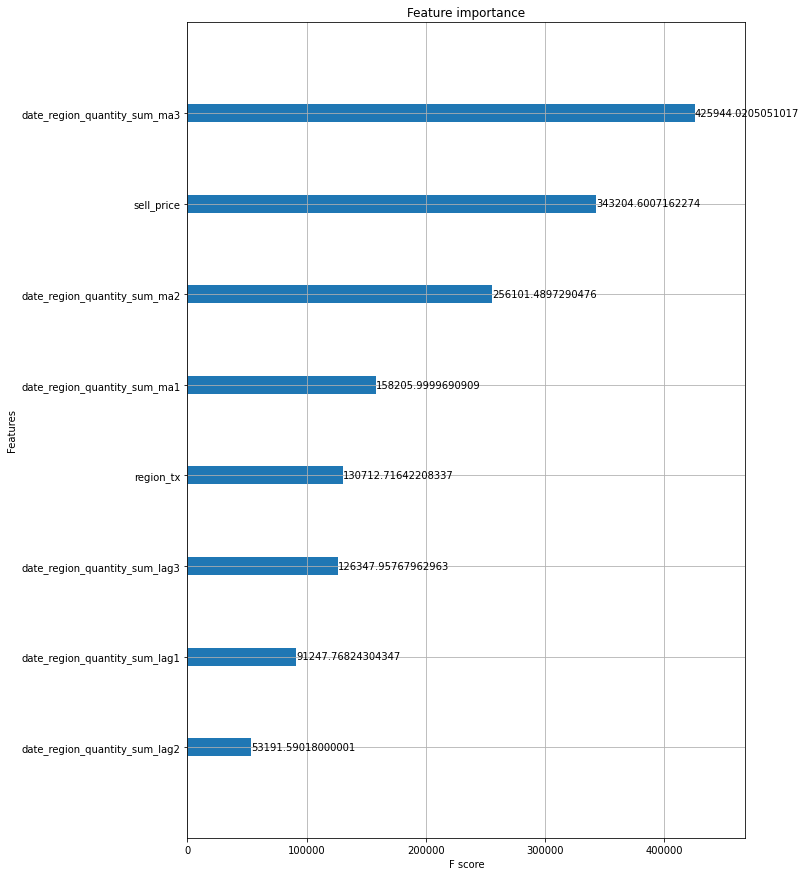

In [ ]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

In [ ]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

10.36432908511652

In [ ]:
Y_valida_pred=pd.DataFrame(Y_valida_pred).rename(columns={0:'quantity'})
Y_valida_pred

,quantity
0,11.047896
1,11.047896
2,11.047896
3,13.426202
4,13.426202
...,...
30485,23.513456
30486,23.513456
30487,21.764585
30488,21.764585


In [ ]:
Y_test=pd.DataFrame(Y_test).rename(columns={0:'quantity'})
Y_test

,quantity
1951360,10.0
1951361,8.0
1951362,9.0
1951363,27.0
1951364,21.0
...,...
1981845,30.0
1981846,30.0
1981847,30.0
1981848,30.0


In [ ]:
Y_train

152450      0.0
152451      0.0
152452      0.0
152453      0.0
152454      0.0
           ... 
1920865    30.0
1920866    24.0
1920867    30.0
1920868    30.0
1920869    30.0
Name: quantity, Length: 1768420, dtype: float64